In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt
import pmdarima as pm
import statsmodels.api


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import warnings

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import LeakyReLU

from collections import deque
import random
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()


data_file = pd.ExcelFile('2020Q1Q2Q3Q4-2021Q1.xlsx')

In [2]:
df_ru = data_file.parse(0)
df_tur = data_file.parse(1)
df_eg = data_file.parse(2)
df_bra = data_file.parse(3)
df_arg = data_file.parse(4)
df_col = data_file.parse(5)
df_sa = data_file.parse(6)
df_sk = data_file.parse(7)

In [3]:
df_col.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      304 non-null    object 
 1   Price     304 non-null    object 
 2   Open      304 non-null    object 
 3   High      304 non-null    object 
 4   Low       304 non-null    object 
 5   Vol.      303 non-null    object 
 6   Change %  303 non-null    float64
dtypes: float64(1), object(6)
memory usage: 16.8+ KB


In [4]:
def timeseries_preprocessing(df):
    #Drop the last row of the dataframe
    df.drop([df.shape[0]-1], axis=0, inplace=True)
    
    # Search if there is K instead of M in volume colum
    k_data = df[df['Vol.'].astype(str).str.contains('K')]
    df = df[df["Vol."].str.contains("K") == False]
    
    #replace with K with nothing and change it to numeric value
    k_data['Vol.'] = k_data['Vol.'].str.replace('K', '')
    k_data['Vol.'] = k_data['Vol.'].apply(pd.to_numeric)
    
    # convert it to M by dividing it by 1000
    k_data['Vol.'] = [(i/1000) for i in k_data['Vol.']]
    
    #join the two dataframe
    df = pd.concat([df, k_data], join="inner")
    
    # remove the (M) and (-) characters
    df['Vol.'] = df['Vol.'].str.replace('M', '').replace('-', '')
    
    # fix the Date column data type to be in a date format instead of object
    df[["Date"]] = df[["Date"]].apply(pd.to_datetime)
    
    # change the Price and other columns data type to int
    df[["Price", "Open", "High", "Low", "Change %", 'Vol.']] = df[["Price", "Open", "High", "Low", "Change %", 'Vol.']].apply(pd.to_numeric)
    
    # make the index equal to Date values
    df = df.sort_values(by=['Date'], ascending=True)  
    
    df = df.drop(columns =['Vol.','Change %'])

    return df

# Colombia - Cementos Argos SA

In [5]:
df = timeseries_preprocessing(df_col)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303 entries, 302 to 0
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    303 non-null    datetime64[ns]
 1   Price   303 non-null    int64         
 2   Open    303 non-null    int64         
 3   High    303 non-null    int64         
 4   Low     303 non-null    int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 14.2 KB


<ipython-input-4-f3766a7b7a0d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  k_data['Vol.'] = k_data['Vol.'].str.replace('K', '')
<ipython-input-4-f3766a7b7a0d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  k_data['Vol.'] = k_data['Vol.'].apply(pd.to_numeric)
<ipython-input-4-f3766a7b7a0d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [6]:
def timeseries_plot(df):
    indexed_dataset = df.set_index('Date')
    indexed_dataset[['Price','Open','High','Low']].plot(figsize=(20,10),linewidth=2,marker='.',colormap='brg',fontsize=20);
    plt.xlabel('Date',fontsize=20);
    plt.ylabel('Values($)',fontsize=20);
    plt.title('Timeseries Plot of High, Low, Open, Closing Price of Stocks',fontsize = 20)
    plt.show() 

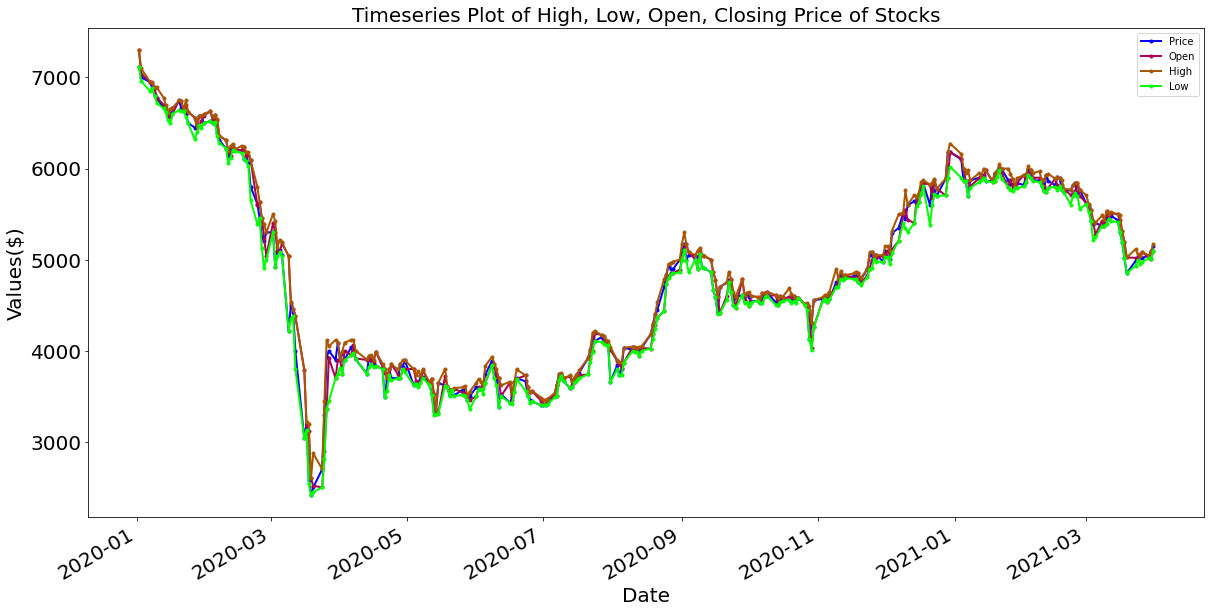

In [7]:
timeseries_plot(df)

In [8]:
def timeseries_plot_closing_value(df):
    
    indexed_dataset = df.set_index('Date')
    indexed_dataset['Price'].plot(figsize=(12,5))
    plt.xlabel('Date',fontsize=20);
    plt.ylabel('Closing Value($)',fontsize=20);
    plt.title('Timeseries of closing stock Price',fontsize = 20)
    plt.show()
    

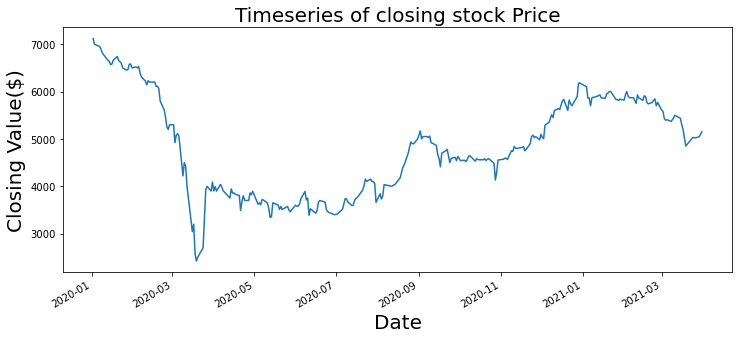

In [9]:
timeseries_plot_closing_value(df)

In [10]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
def acf_pacf_plot(df):
    indexed_dataset = df.set_index('Date')
    df_close= indexed_dataset['Price']
    fig = plt.figure(figsize = (12,8))
    ax1 = fig.add_subplot(211)
    fig = plot_acf(df_close,lags=20,ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = plot_pacf(df_close,lags=20,ax=ax2)


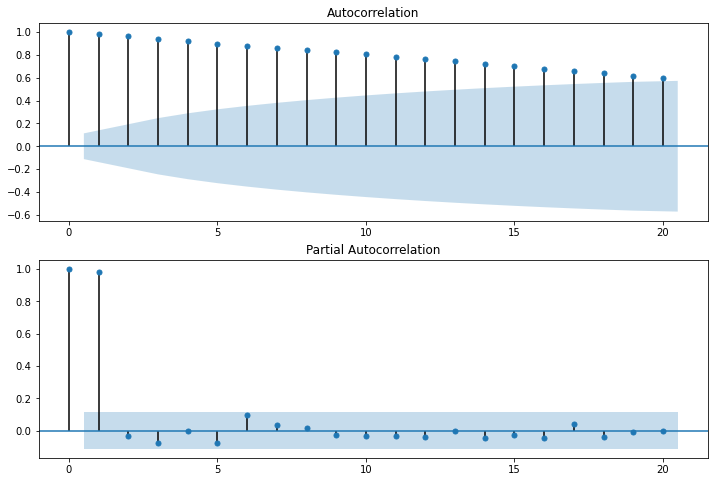

In [11]:
acf_pacf_plot(df)

# Dickey Fuller Test

In [12]:
#If the dataset is not stationary--

def stationary(df):
    result = adfuller(df.Price.values, autolag='AIC')
    if result[1] > 0.05:
        print(f'The p-value is {result[1]} reject the null hypthesis and data is not stationary')
        result = adfuller(np.diff(df.Price.values), autolag='AIC')
    if result[1] < 0.05:
        print(f'The p-value after first difference is {result[1]}, accept the null hypothesis and data is stationary')
        difference = df.Price.diff()
        df['Difference'] = difference
    else:
        print('Your time series is not stationary, you may need to make another difference')
    return df

In [13]:
df = stationary(df)

The p-value is 0.23528318144575572 reject the null hypthesis and data is not stationary
The p-value after first difference is 1.2918069920928453e-11, accept the null hypothesis and data is stationary


In [14]:
df = df.dropna()
df

,Date,Price,Open,High,Low,Difference
301,2020-01-03,7000,7040,7100,6960,-120.0
300,2020-01-07,6950,6950,6950,6850,-50.0
299,2020-01-08,6880,6940,6950,6880,-70.0
298,2020-01-09,6810,6880,6890,6800,-70.0
297,2020-01-10,6770,6780,6890,6720,-40.0
...,...,...,...,...,...,...
4,2021-03-25,5030,5035,5045,4950,5.0
3,2021-03-26,5020,5085,5085,4980,-10.0
2,2021-03-29,5045,5020,5045,5015,25.0
1,2021-03-30,5100,5010,5100,5010,55.0


In [15]:
df_final = df.set_index('Date')

In [16]:
df_final.tail()

,Price,Open,High,Low,Difference
Date,,,,,
2021-03-25,5030,5035,5045,4950,5.0
2021-03-26,5020,5085,5085,4980,-10.0
2021-03-29,5045,5020,5045,5015,25.0
2021-03-30,5100,5010,5100,5010,55.0
2021-03-31,5150,5100,5170,5100,50.0


In [17]:
df_train = df_final.loc[:'2020']
df_test = df_final.loc['2021':]

In [18]:
#use a for loop for testing data! for 61 days

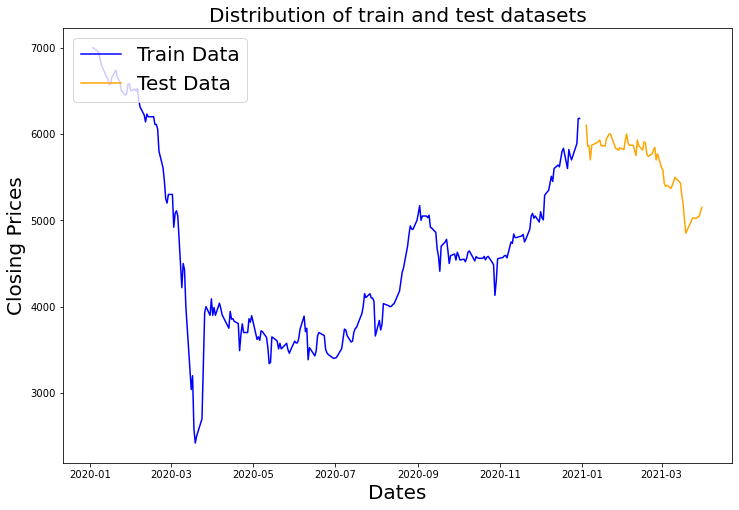

In [19]:
plt.figure(figsize=(12,8))
plt.plot(df_train['Price'],color='blue', label='Train Data')
plt.plot(df_test['Price'],color='orange', label='Test Data')
plt.xlabel('Dates',fontsize=20)
plt.ylabel('Closing Prices',fontsize=20)
plt.legend(loc='upper left',fontsize=20)
plt.title('Distribution of train and test datasets',fontsize=20)
plt.show()

In [20]:
df_train

,Price,Open,High,Low,Difference
Date,,,,,
2020-01-03,7000,7040,7100,6960,-120.0
2020-01-07,6950,6950,6950,6850,-50.0
2020-01-08,6880,6940,6950,6880,-70.0
2020-01-09,6810,6880,6890,6800,-70.0
2020-01-10,6770,6780,6890,6720,-40.0
...,...,...,...,...,...
2020-12-23,5750,5870,5890,5720,-70.0
2020-12-24,5700,5780,5780,5700,-50.0
2020-12-28,5890,5705,5890,5705,190.0


In [21]:
df_test

,Price,Open,High,Low,Difference
Date,,,,,
2021-01-04,6100,6110,6160,5900,-80.0
2021-01-05,5860,6000,6000,5860,-240.0
2021-01-06,5865,5860,5955,5860,5.0
2021-01-07,5700,5860,5985,5700,-165.0
2021-01-08,5870,5805,5870,5790,170.0
...,...,...,...,...,...
2021-03-25,5030,5035,5045,4950,5.0
2021-03-26,5020,5085,5085,4980,-10.0
2021-03-29,5045,5020,5045,5015,25.0


## ARIMA Model

In [22]:
 arima_model = pm.auto_arima(df_train.Price, start_p=1, start_q=1, test='adf', max_p=6, max_q=6, 
                      m=1, d=None, seasonal=False, start_P=0, D=1, trace=False, error_action='ignore',  
                      suppress_warnings=True, stepwise=False)

In [23]:
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  241
Model:               SARIMAX(0, 1, 5)   Log Likelihood               -1551.199
Date:                Thu, 23 Jun 2022   AIC                           3116.399
Time:                        13:11:23   BIC                           3140.763
Sample:                             0   HQIC                          3126.216
                                - 241                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.5416     15.130     -0.102      0.919     -31.196      28.113
ma.L1          0.0757      0.049      1.534      0.125      -0.021       0.173
ma.L2          0.1089      0.056      1.929      0.0

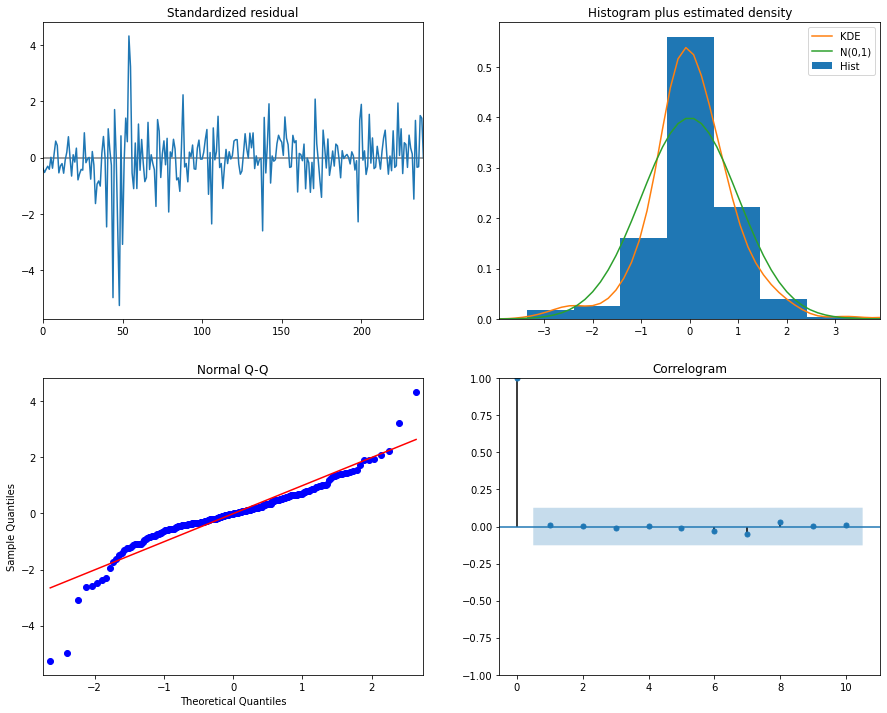

In [24]:
arima_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [25]:
arima = statsmodels.tsa.arima.model.ARIMA(df_train.Price,order=(0, 1, 5))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [26]:
arima_fit = arima.fit()

In [27]:
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  241
Model:                 ARIMA(0, 1, 5)   Log Likelihood               -1551.224
Date:                Thu, 23 Jun 2022   AIC                           3114.448
Time:                        13:11:25   BIC                           3135.332
Sample:                             0   HQIC                          3122.863
                                - 241                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0759      0.049      1.537      0.124      -0.021       0.173
ma.L2          0.1091      0.056      1.964      0.050       0.000       0.218
ma.L3          0.0567      0.056      1.008      0.3

In [28]:
y_pred = arima_model.predict(len(df_test['Price']))

In [29]:
y_pred

array([6213.27316948, 6270.57714161, 6276.46416143, 6246.45657488,
       6245.0976963 , 6243.55610599, 6242.01451568, 6240.47292538,
       6238.93133507, 6237.38974476, 6235.84815445, 6234.30656414,
       6232.76497383, 6231.22338352, 6229.68179321, 6228.1402029 ,
       6226.59861259, 6225.05702228, 6223.51543197, 6221.97384167,
       6220.43225136, 6218.89066105, 6217.34907074, 6215.80748043,
       6214.26589012, 6212.72429981, 6211.1827095 , 6209.64111919,
       6208.09952888, 6206.55793857, 6205.01634826, 6203.47475796,
       6201.93316765, 6200.39157734, 6198.84998703, 6197.30839672,
       6195.76680641, 6194.2252161 , 6192.68362579, 6191.14203548,
       6189.60044517, 6188.05885486, 6186.51726455, 6184.97567425,
       6183.43408394, 6181.89249363, 6180.35090332, 6178.80931301,
       6177.2677227 , 6175.72613239, 6174.18454208, 6172.64295177,
       6171.10136146, 6169.55977115, 6168.01818084, 6166.47659054,
       6164.93500023, 6163.39340992, 6161.85181961, 6160.31022

In [30]:
fc = len(df_test['Price'])
fc_series = pd.Series(y_pred,index=df_test['Price'].index)

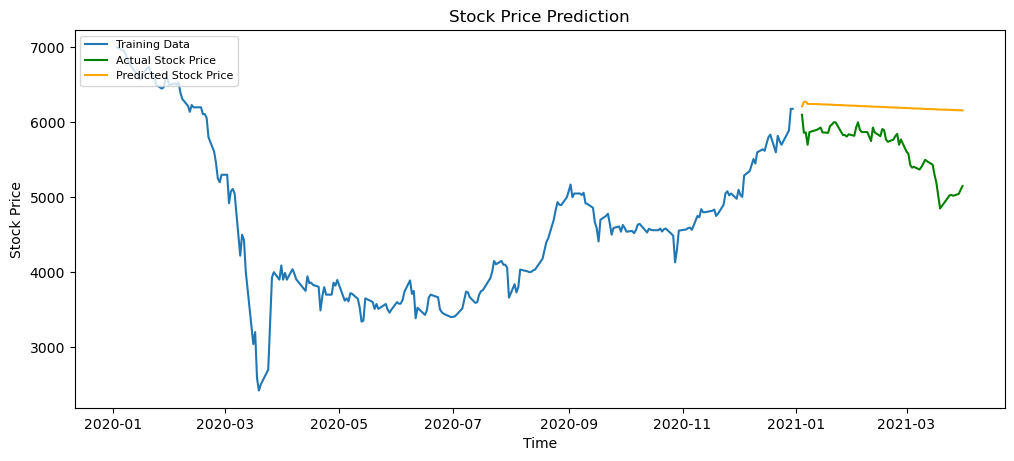

In [31]:
plt.figure(figsize=(12,5),dpi=100)
plt.plot(df_train.Price,label='Training Data')
plt.plot(df_test.Price,color='green',label='Actual Stock Price')
plt.plot(fc_series,color='orange',label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper left',fontsize=8)
plt.show()

In [32]:
fc_series

Date
2021-01-04    6213.273169
2021-01-05    6270.577142
2021-01-06    6276.464161
2021-01-07    6246.456575
2021-01-08    6245.097696
                 ...     
2021-03-25    6164.935000
2021-03-26    6163.393410
2021-03-29    6161.851820
2021-03-30    6160.310229
2021-03-31    6158.768639
Length: 61, dtype: float64

In [33]:
mape = np.mean(np.abs(fc-df_test['Price'])/np.abs(df_test['Price']))
print(mape)

0.989161590969493


In [34]:
 mean_absolute_error(df_test.Price, y_pred)

557.2944525122332

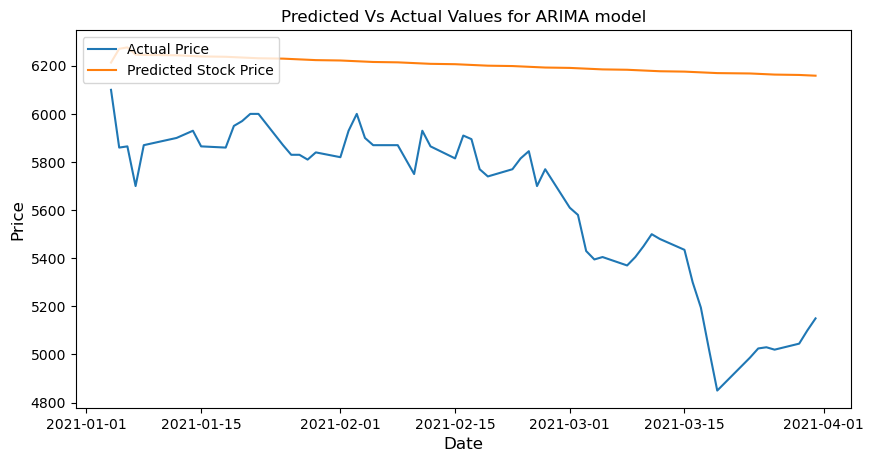

In [35]:
plt.figure(figsize=(10,5),dpi=100)
plt.plot(df_test.Price,label='Actual Price')
plt.plot(fc_series,label='Predicted Stock Price')
plt.title('Predicted Vs Actual Values for ARIMA model')
plt.xlabel('Date',fontsize=12)
plt.ylabel('Price',fontsize=12)
plt.legend(loc='upper left',fontsize=10)
plt.show()

## Time Series Cross Validation

Observations: 152
Training Observations: 77
Testing Observations: 75


<Figure size 432x288 with 0 Axes>

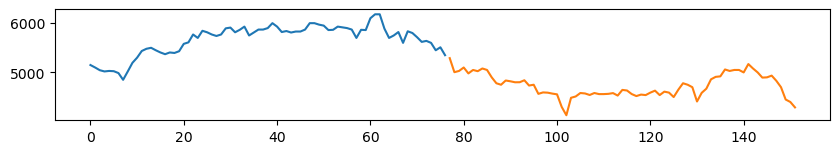

Observations: 227
Training Observations: 152
Testing Observations: 75


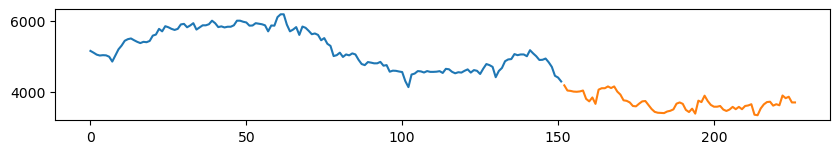

Observations: 302
Training Observations: 227
Testing Observations: 75


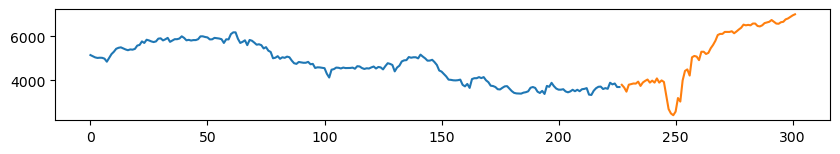

In [36]:

from pandas import read_csv
from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot

X = df.Price
splits = TimeSeriesSplit(n_splits=3)
pyplot.figure(1)
index = 1
for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]
    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))
    plt.figure(figsize=(10,5),dpi=100)
    pyplot.subplot(310 + index)
    pyplot.plot(train)
    pyplot.plot([None for i in train] + [x for x in test])
    index += 1
    pyplot.show()

In [37]:
from matplotlib import pyplot

X = df.Price
n_train = 249
n_records = len(X)
for i in range(n_train, n_records):
	train, test = X[0:i], X[i:i+1]
	print('train=%d, test=%d' % (len(train), len(test)))

train=249, test=1
train=250, test=1
train=251, test=1
train=252, test=1
train=253, test=1
train=254, test=1
train=255, test=1
train=256, test=1
train=257, test=1
train=258, test=1
train=259, test=1
train=260, test=1
train=261, test=1
train=262, test=1
train=263, test=1
train=264, test=1
train=265, test=1
train=266, test=1
train=267, test=1
train=268, test=1
train=269, test=1
train=270, test=1
train=271, test=1
train=272, test=1
train=273, test=1
train=274, test=1
train=275, test=1
train=276, test=1
train=277, test=1
train=278, test=1
train=279, test=1
train=280, test=1
train=281, test=1
train=282, test=1
train=283, test=1
train=284, test=1
train=285, test=1
train=286, test=1
train=287, test=1
train=288, test=1
train=289, test=1
train=290, test=1
train=291, test=1
train=292, test=1
train=293, test=1
train=294, test=1
train=295, test=1
train=296, test=1
train=297, test=1
train=298, test=1
train=299, test=1
train=300, test=1
train=301, test=1


In [38]:
x = df_final['Price']
size = int(len(x) * 0.90)
n_train = size
n_records = len(x)
for i in range(n_train, n_records):
  train, test = x[0:i], x[i:i+1]
  

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

prediction = []
data = train.values
for t in test.values:
   model = ARIMA(data, order=(0, 1, 5)).fit(disp=0)
   y = model.forecast(steps=len(test))[0]
   prediction.append(y[0])
   data = np.append(data, t)

test_ = pd.DataFrame(test)
test_['predictions_wf'] = prediction
print(test_)

            Price  predictions_wf
Date                             
2021-03-31   5150     5092.459884


In [39]:
import warnings
from math import sqrt

# split into train and test sets
size = int(len(x) * 0.90)
train, test = x[0:size], x[size:len(x)]
# print(len(train)); len(test)) # 2377, 265

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

prediction = []
data = train.values
for t in test.values:
   model = ARIMA(data, order=(0, 1, 5)).fit(disp=0)
   y = model.forecast(steps=len(test))[0]
   prediction.append(y[0])
   data = np.append(data, t)

test_ = pd.DataFrame(test)
test_['predictions_wf'] = prediction
print(test_)

            Price  predictions_wf
Date                             
2021-02-16   5910     5807.916551
2021-02-17   5895     5934.125981
2021-02-18   5770     5862.819386
2021-02-19   5740     5760.883719
2021-02-22   5770     5744.349234
2021-02-23   5815     5742.739828
2021-02-24   5845     5809.999483
2021-02-25   5700     5860.922049
2021-02-26   5770     5695.663655
2021-03-01   5610     5763.445548
2021-03-02   5580     5591.051609
2021-03-03   5430     5534.372416
2021-03-04   5395     5442.297937
2021-03-05   5405     5343.407212
2021-03-08   5370     5413.465180
2021-03-09   5405     5352.596515
2021-03-10   5450     5407.857074
2021-03-11   5500     5465.985414
2021-03-12   5480     5489.395020
2021-03-15   5435     5492.218641
2021-03-16   5300     5424.883723
2021-03-17   5195     5278.099044
2021-03-18   5020     5161.762802
2021-03-19   4850     4982.005436
2021-03-23   4987     4803.158264
2021-03-24   5025     4979.375312
2021-03-25   5030     5027.124749
2021-03-26   5

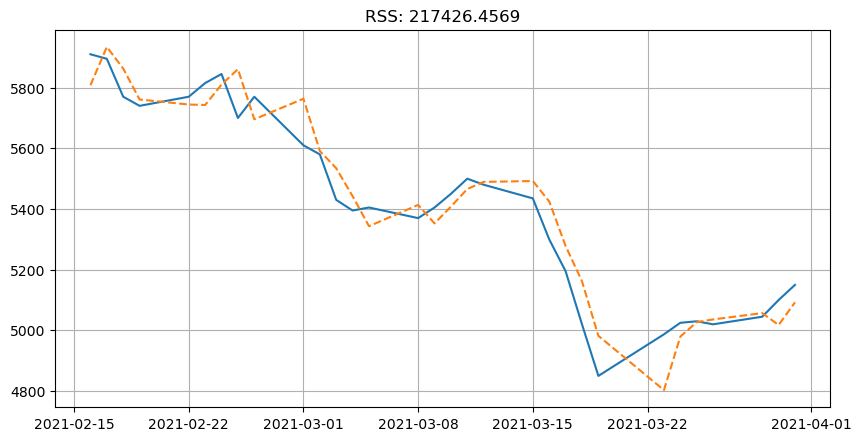

Test RMSE for ARIMA with Walk-Forward Validation:  83.74817415245273


In [40]:
plt.figure(figsize=(10,5),dpi=100)
plt.plot(test_['Price'])
plt.plot(test_.predictions_wf, '--')
plt.title('RSS: %.4f'% sum((test_.predictions_wf - test_['Price'])**2))
plt.grid(True);plt.show()
error = sqrt(mean_squared_error(test.values, prediction))
print ('Test RMSE for ARIMA with Walk-Forward Validation: ', error)

In [41]:
mape = np.mean(np.abs(prediction-test.values)/np.abs(test.values))
print(mape)

0.012730859564272405


# LSTM Model

In [42]:
df = timeseries_preprocessing(df_col)

<ipython-input-4-f3766a7b7a0d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  k_data['Vol.'] = k_data['Vol.'].str.replace('K', '')
<ipython-input-4-f3766a7b7a0d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  k_data['Vol.'] = k_data['Vol.'].apply(pd.to_numeric)
<ipython-input-4-f3766a7b7a0d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [43]:
df

,Date,Price,Open,High,Low
301,2020-01-03,7000,7040,7100,6960
300,2020-01-07,6950,6950,6950,6850
299,2020-01-08,6880,6940,6950,6880
298,2020-01-09,6810,6880,6890,6800
297,2020-01-10,6770,6780,6890,6720
...,...,...,...,...,...
4,2021-03-25,5030,5035,5045,4950
3,2021-03-26,5020,5085,5085,4980
2,2021-03-29,5045,5020,5045,5015
1,2021-03-30,5100,5010,5100,5010


In [44]:
df['Year'] = pd.DatetimeIndex(df['Date']).year

In [45]:
train_test_boundary = df[df['Year'] == 2020].index[-1] #extracting the index of where 2020 data finishes

In [46]:
train_test_boundary

61

In [47]:
date_arr = df['Date'].to_numpy() #storing date as we would need this at a later point

In [48]:
df = df.set_index('Date')

In [49]:
df

,Price,Open,High,Low,Year
Date,,,,,
2020-01-03,7000,7040,7100,6960,2020
2020-01-07,6950,6950,6950,6850,2020
2020-01-08,6880,6940,6950,6880,2020
2020-01-09,6810,6880,6890,6800,2020
2020-01-10,6770,6780,6890,6720,2020
...,...,...,...,...,...
2021-03-25,5030,5035,5045,4950,2021
2021-03-26,5020,5085,5085,4980,2021
2021-03-29,5045,5020,5045,5015,2021


In [50]:
#removing the Year column
df = df.drop(columns = ['Year'])

In [51]:
#global variables
n_steps = 3
n_features = 1


In [52]:
#normalize the data
scaler = MinMaxScaler()
cols = df.columns
df[cols] = scaler.fit_transform(df[cols])

In [53]:
#defining the training dataframe
train_df = df[:-train_test_boundary]
    
#defining the testing dataframe
test_df = df[-train_test_boundary:]

In [54]:
train_df.shape

(241, 4)

In [55]:
test_df.shape

(61, 4)

In [56]:
def split_sequence(data, n_steps):
    X, y = list(), list()
    for i in range(len(data)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(data)-1:
            break
        # gather input and output parts of the pattern
        seq_x_price = data['Price'].iloc[i:end_ix]
        seq_y = data['Price'].iloc[end_ix]
        x = np.empty((3,n_features))
        for idx in range(n_steps):
            x[idx, 0] = seq_x_price[idx]
        y.append(seq_y)
        X.append(x)
    return np.array(X), np.array(y)

In [57]:
#creating training set and labels with a n_step of 3
X_train, y_train = split_sequence(train_df, n_steps)
    
#creating training set and labels with a n_step of 3
X_test, y_test = split_sequence(test_df, n_steps)

In [58]:
X_train.shape,y_train.shape

((238, 3, 1), (238,))

In [59]:
X_test.shape,y_test.shape

((58, 3, 1), (58,))

In [60]:
# define model
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(256, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
model.add(tf.keras.layers.LSTM(64, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse', metrics=['mse'])
    
# reshape from [samples, timesteps] into [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features)) 
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features)
    
# fit model
history = model.fit(X_train, y_train, epochs=250, verbose=0, validation_data = (X_test, y_test))

C:\Users\rames\AppData\Roaming\Python\Python38\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


In [61]:
#generating the predicted array using model.predict
forecast = []
y_hat = []

for time in range (len(df) - n_steps):
    X = df['Price'].to_numpy()
    pred = model.predict(X[time:time+n_steps].reshape(1,3,1))
    forecast.append(pred)

y_hat = np.array(forecast)

y_hat = np.append(y_hat[:, 0], np.zeros((y_hat[:, 0].shape[0], 3)), axis=1) 
y_hat = scaler.inverse_transform(y_hat) #converting the normalized data back to its orginal 

df = scaler.inverse_transform(df)

df_final = pd.DataFrame()
df_final['Actual Price'], df_final['Predicted Price'], df_final["Date"] = df[3:, 0], y_hat[:, 0], date_arr[3:]
df_final = df_final.set_index('Date')

C:\Users\rames\AppData\Roaming\Python\Python38\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [62]:
df_final

,Actual Price,Predicted Price
Date,,
2020-01-09,6810.0,6957.302840
2020-01-10,6770.0,6892.350775
2020-01-13,6660.0,6824.194635
2020-01-14,6640.0,6751.457462
2020-01-15,6570.0,6690.362190
...,...,...
2021-03-25,5030.0,4947.022390
2021-03-26,5020.0,5022.441956
2021-03-29,5045.0,5038.779818


In [63]:
#calculate rmse
from sklearn.metrics import mean_squared_error
from math import sqrt
df_final = df_final.dropna(axis=0)
rmse = sqrt(mean_squared_error(df_final['Actual Price'], df_final['Predicted Price']))
print("Root Mean Squared Error is", rmse)

df_final_copy = df_final

Root Mean Squared Error is 205.229952323392


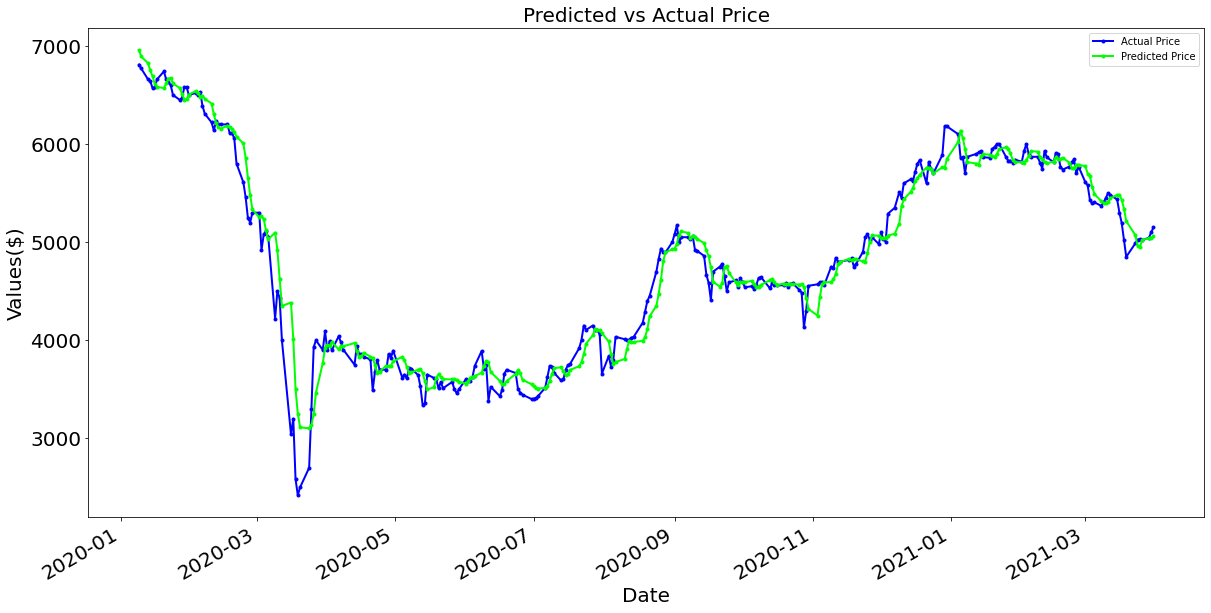

In [64]:
df_final[['Actual Price','Predicted Price']].plot(figsize=(20,10),linewidth=2,marker='.',colormap='brg',fontsize=20);
plt.xlabel('Date',fontsize=20);
plt.ylabel('Values($)',fontsize=20);
plt.title('Predicted vs Actual Price',fontsize = 20)
plt.show() 

<Figure size 432x288 with 0 Axes>

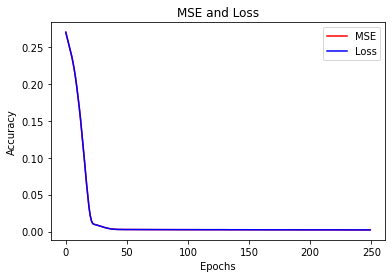

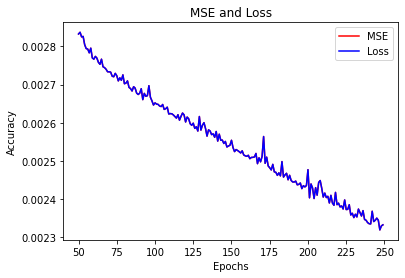

<Figure size 432x288 with 0 Axes>

In [65]:
mse=history.history['mse']
loss=history.history['loss']

epochs=range(len(loss))

plt.plot(epochs, mse, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MSE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MSE", "Loss"])


plt.figure()

epochs_zoom = epochs[50:]
mse_zoom = mse[50:]
loss_zoom = loss[50:]

plt.plot(epochs_zoom, mse_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MSE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MSE", "Loss"])

plt.figure()


In [66]:
#bollinger bands calculation
def sma(data, window):
    sma = data.rolling(window = window).mean()
    return sma

def bb(data, sma, window):
    std = data.rolling(window = window).std()
    upper_bb = sma + std * 2
    lower_bb = sma - std * 2
    return upper_bb, lower_bb

def implement_bb_strategy(data, lower_bb, upper_bb):
    buy_price = []
    sell_price = []
    bb_signal = []
    signal = 0
    
    for i in range(1, len(data)):
        if data.iloc[i-1] > lower_bb.iloc[i-1] and data.iloc[i] < lower_bb.iloc[i]:
            if signal != 1:
                buy_price.append(data.iloc[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        elif data.iloc[i-1] < upper_bb.iloc[i-1] and data.iloc[i] > upper_bb.iloc[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data.iloc[i])
                signal = -1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)
            
    return buy_price, sell_price, bb_signal

In [67]:
investment_returns = []
sma_params = []
bb_params = []
        
for sma_param in np.linspace(10, 100, 10).astype(int):
    df_final = df_final_copy
    df_final['sma_20'] = sma(df_final['Predicted Price'], sma_param)
    for bb_param in np.linspace(10, 100, 10).astype(int):
        df_final['upper_bb'], df_final['lower_bb'] = bb(df_final['Predicted Price'], df_final['sma_20'], bb_param)
        buy_price, sell_price, bb_signal = implement_bb_strategy(df_final['Predicted Price'], df_final['lower_bb'], df_final['upper_bb'])
        buy_price.insert(0, None)
        sell_price.insert(0, None)
        bb_signal.insert(0, None)

        position = []
        for i in range(len(bb_signal)):
            if bb_signal[i] == None:
                position.append(None)
                continue
            if bb_signal[i] > 1:
                position.append(0)
            else:
                position.append(1)

        for i in range(len(df_final['Predicted Price'])):
            if bb_signal[i] == None:
                continue
            if bb_signal[i] == 1:
                position[i] = 1
            elif bb_signal[i] == -1:
                position[i] = 0
            else:
                position[i] = position[i-1]

        upper_bb = df_final['upper_bb']
        lower_bb = df_final['lower_bb']
        close_price = df_final['Predicted Price']
        bb_signal = pd.DataFrame(bb_signal).rename(columns = {0:'bb_signal'}).set_index(df_final.index)
        position = pd.DataFrame(position).rename(columns = {0:'bb_position'}).set_index(df_final.index)

        frames = [close_price, upper_bb, lower_bb, bb_signal, position]
        strategy = pd.concat(frames, join = 'inner', axis = 1)
        
        #backtesting on actual price
        price_diff = np.diff(df_final['Actual Price'])
        list(price_diff).insert(0, None)
        df_final_ret = pd.DataFrame(price_diff).rename(columns = {0:'returns'})
        bb_strategy_ret = []

        for i in range(len(df_final_ret)):
            try:
                returns = df_final_ret['returns'][i]*strategy['bb_position'][i]
                bb_strategy_ret.append(returns)
            except:
                bb_strategy_ret.append(np.nan)

        bb_strategy_ret.insert(0, None)
        bb_strategy_ret_df = pd.DataFrame(bb_strategy_ret).rename(columns = {0:'bb_returns'})
        bb_strategy_ret_df

        investment = 100000
        stocks = 0

        for i in range(len(bb_strategy_ret_df['bb_returns'])):
            if strategy['bb_signal'].iloc[i] == None:
                continue
            if strategy['bb_signal'].iloc[i] == 1:
                stocks = int(investment/df_final['Actual Price'].iloc[i])
            returns = stocks * bb_strategy_ret_df['bb_returns'].iloc[i]
            if str(returns) != 'nan':
                investment = investment + returns
        investment_returns.append(investment - 100000)
        sma_params.append(sma_param)
        bb_params.append(bb_param)
        
max_idx = np.argmax(np.array(investment_returns))
print("Highest return is ${} with sma of {} using a bollinger parameter {}". 
      format(investment_returns[max_idx], sma_params[max_idx], bb_params[max_idx]))

Highest return is $52365.0 with sma of 20 using a bollinger parameter 40


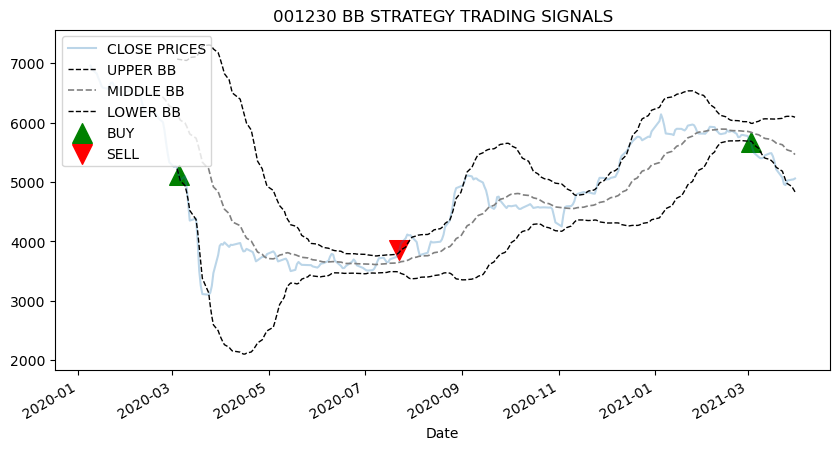

In [68]:
df_final['sma'] = sma(df_final['Predicted Price'], 30)
df_final['upper_bb'], df_final['lower_bb'] = bb(df_final['Predicted Price'], df_final['sma'], 40)
buy_price, sell_price, bb_signal = implement_bb_strategy(df_final['Predicted Price'], df_final['lower_bb'], df_final['upper_bb'])
buy_price.insert(0, None)
sell_price.insert(0, None)
bb_signal.insert(0, None)
plt.figure(figsize=(10,5),dpi=100)
df_final['Predicted Price'].plot(label = 'CLOSE PRICES', alpha = 0.3)
df_final['upper_bb'].plot(label = 'UPPER BB', linestyle = '--', linewidth = 1, color = 'black')
df_final['sma'].plot(label = 'MIDDLE BB', linestyle = '--', linewidth = 1.2, color = 'grey')
df_final['lower_bb'].plot(label = 'LOWER BB', linestyle = '--', linewidth = 1, color = 'black')
plt.scatter(df_final.index, buy_price, marker = '^', color = 'green', label = 'BUY', s = 200)
plt.scatter(df_final.index, sell_price, marker = 'v', color = 'red', label = 'SELL', s = 200)
plt.title('001230 BB STRATEGY TRADING SIGNALS')
plt.legend(loc = 'upper left')
plt.show()